In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.transforms import transforms
from torchvision.models import ResNet18_Weights
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image

### Helper Methods

In [17]:
def get_train_val(filepath: str, val_size=0.2):
    data = []
    with open(file=filepath) as f:
        for row in f.readlines():
            row = row.strip().split(' ')
            row[1], row[2], row[3] = int(row[1]), int(row[2]), int(row[3])
            data.append(row)
    df = pd.DataFrame(data=data, columns=['image_id', 'class_id', 'species', 'breed'])
    
    # Replace 1 with 0 (for cats) and 2 with 1 (for dogs)
    df['species'] = df['species'].replace({1: 0, 2: 1})
    train_df, val_df = train_test_split(df, test_size=val_size, stratify=df['species'], shuffle=True, random_state=42)
    return train_df, val_df


def get_test(filepath: str):
    data = []
    with open(file=filepath) as f:
        for row in f.readlines():
            row = row.strip().split(' ')
            row[1], row[2], row[3] = int(row[1]), int(row[2]), int(row[3])
            data.append(row)
    df = pd.DataFrame(data=data, columns=['image_id', 'class_id', 'species', 'breed'])
    
    # Replace 1 with 0 (for cats) and 2 with 1 (for dogs)
    df['species'] = df['species'].replace({1: 0, 2: 1})
    return df


def load_and_transform_image(image_path, transformations, augment):
    """ Load an image and apply the transformations. """
    
    # Define the transformations (we use the same as what Resnet used for efficient transfer)
    if augment:
        # Add data augmentation on training data
        transformations.append(transforms.RandomHorizontalFlip())
        transformations.append(transforms.RandomRotation(10))
    transform = transforms.Compose(transformations)
    image = Image.open(image_path).convert('RGB')  # Convert all images to RGB
    return transform(image)


# Function to create a tensor dataset from DataFrame and transformations
def create_dataset(df, base_path, transformations, augment=False):
    images_tensors = []
    Y = []
    for row in df.values.tolist():
        image_id, species_id = row[0], row[2]
        image_path = f"{base_path}{image_id}.jpg"  # Adjust format as needed
        image_tensor = load_and_transform_image(image_path, transformations, augment)
        images_tensors.append(image_tensor)
        Y.append(species_id)
    
    # Stack all tensors to create a single tensor
    X = torch.stack(images_tensors)
    Y = torch.tensor(np.array(Y))
    return X, Y


def show_images(images, labels, n_images=None, figsize=(8, 8)):
    """
    Display a grid of images with labels.
    """
    if n_images is None:
        n_images = len(images)
    else:
        images = images[:n_images]
        labels = labels[:n_images]
    
    num_rows = int(np.ceil(n_images**0.5))
    num_cols = int(np.ceil(n_images / num_rows))

    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        # The image tensor shape should be (channels, height, width)
        img = img.permute(1, 2, 0).numpy()  # Convert to (height, width, channels)
        ax.imshow(img)
        ax.axis('off')  # Hide the axes ticks
        ax.set_title(f"Label: {label.item()}", fontsize=10)  # Set title to the label of the image

    plt.tight_layout()
    plt.show()

### Defome the base class for Image Classification

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):

        images, labels = batch 
        out = self(images)
        with torch.no_grad():
            loss = F.cross_entropy(out, labels)   
            acc = accuracy(out, labels)           
        
        return {'loss': loss.detach(), 'acc': acc}

In [19]:
class DogsCatsCnnModelResNet18(ImageClassificationBase):
    def __init__(self):
        
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [20]:
@torch.no_grad()
def evaluate(model: ImageClassificationBase, X_val, Y_val):

    model.eval()
    batch = [X_val, Y_val]
    outputs = model.validation_step(batch)
    
    return outputs

def fit(model: ImageClassificationBase, epochs, lr, X_train, Y_train, X_val, Y_val, batch_size=32, opt_func=torch.optim.SGD):

    history = {
        'val': [],
        'train': []
    }
    optimizer = opt_func(model.parameters(), lr)

    # Create TensorDataset and DataLoader for training data
    np.random.seed(42)
    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Evaluate on no training first
    result_val = evaluate(model, X_val, Y_val)
    result_train = evaluate(model, X_train, Y_train)
    history['val'].append(result_val)
    history['train'].append(result_train)
    print(f"Epoch 0, val: {result_val}")
    print(f"Epoch 0, train: {result_train}")

    min_loss = np.inf
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}")
                
        # Training Phase 
        model.train()
        train_losses = []
        for i, batch in enumerate(train_loader):
            print(f"  - Batch {i}/{int(len(X_train) / batch_size)}")
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result_val = evaluate(model, X_val, Y_val)
        result_train = evaluate(model, X_train, Y_train)
        history['val'].append(result_val)
        history['train'].append(result_train)
        print(f"    > val: {result_val}")
        print(f"    > train: {result_train}")

        if result_val['loss'] < min_loss:
            min_loss = result_val['loss']
            best_model = model
        
    return best_model, history

In [21]:
def plot_results(history):
    val_hist = history['val']
    train_hist = history['train']
    val_loss = [d['loss'] for d in val_hist]
    val_acc = [d['acc'] for d in val_hist]
    train_loss = [d['loss'] for d in train_hist]
    train_acc = [d['acc'] for d in train_hist]

    plt.style.use('dark_background')

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel('Update')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.xlabel('Update')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

In [22]:
model_resnet_18 = DogsCatsCnnModelResNet18()

In [23]:
df_train, df_val = get_train_val(filepath='datasets/annotations/trainval.txt', val_size=0.2)
transformations = [
    transforms.Resize((224, 224)),             # Resize the images to 224x224 pixels
    transforms.ToTensor(),                     # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean and std
                         std=[0.229, 0.224, 0.225])
]
X_train, Y_train = create_dataset(df_train, base_path='datasets/images/', transformations=transformations, augment=False)
X_val, Y_val = create_dataset(df_val, base_path='datasets/images/', transformations=transformations, augment=False)

In [24]:
num_epochs = 10
opt_func = torch.optim.Adam
batch_size = 128
lr = 0.00025

best_model, history = fit(model_resnet_18, num_epochs, lr, X_train, Y_train, X_val, Y_val, batch_size, opt_func)

Epoch 0, val: {'loss': tensor(0.8046), 'acc': tensor(0.2473)}
Epoch 0, train: {'loss': tensor(0.8012), 'acc': tensor(0.2544)}
Epoch: 1
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': tensor(0.3348), 'acc': tensor(0.9823)}
    > train: {'loss': tensor(0.3221), 'acc': tensor(0.9935)}
Epoch: 2
  - Batch 0/23
  - Batch 1/23
  - Batch 2/23
  - Batch 3/23
  - Batch 4/23
  - Batch 5/23
  - Batch 6/23
  - Batch 7/23
  - Batch 8/23
  - Batch 9/23
  - Batch 10/23
  - Batch 11/23
  - Batch 12/23
  - Batch 13/23
  - Batch 14/23
  - Batch 15/23
  - Batch 16/23
  - Batch 17/23
  - Batch 18/23
  - Batch 19/23
  - Batch 20/23
  - Batch 21/23
  - Batch 22/23
    > val: {'loss': 

In [25]:
best_model

DogsCatsCnnModelResNet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [26]:
def get_test(filepath: str):
    data = []
    with open(file=filepath) as f:
        for row in f.readlines():
            row = row.strip().split(' ')
            row[1], row[2], row[3] = int(row[1]), int(row[2]), int(row[3])
            data.append(row)
    df = pd.DataFrame(data=data, columns=['image_id', 'class_id', 'species', 'breed'])
    
    # Replace 1 with 0 (for cats) and 2 with 1 (for dogs)
    df['species'] = df['species'].replace({1: 0, 2: 1})
    return df

In [27]:
df_test = get_test(filepath='datasets/annotations/test.txt')
transformations = [
    transforms.Resize((224, 224)),             # Resize the images to 224x224 pixels
    transforms.ToTensor(),                     # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean and std
                         std=[0.229, 0.224, 0.225])
]
X_test, Y_test = create_dataset(df_test, base_path='datasets/images/', transformations=transformations, augment=False)

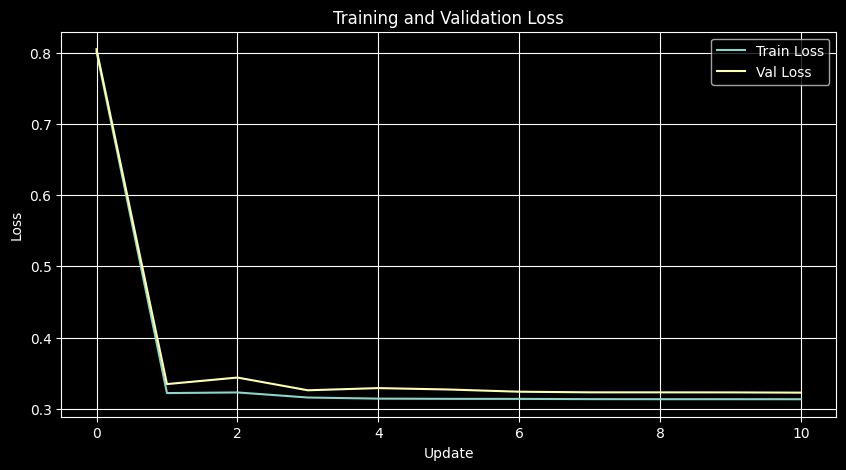

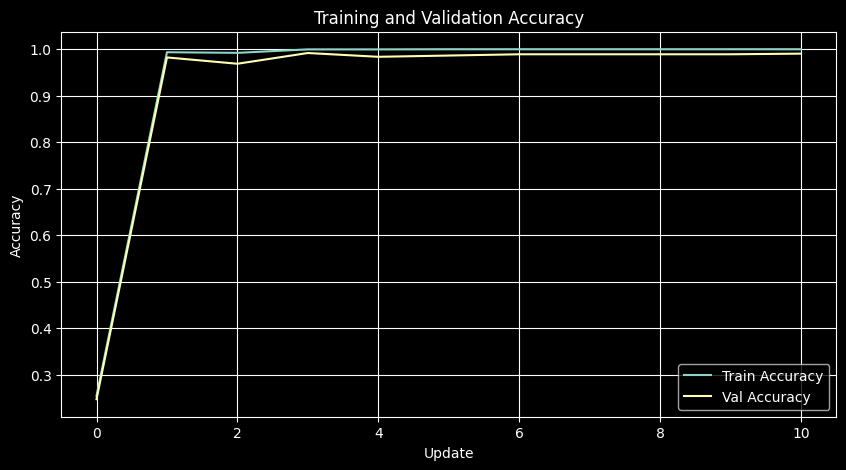

In [28]:
plot_results(history)

In [29]:
evaluate(best_model, X_test, Y_test)

{'loss': tensor(0.3245), 'acc': tensor(0.9888)}